In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import math
from minGPT.mingpt.utils import set_seed
import numpy as np
def approx_equals(a, b):
    assert torch.allclose(a, b, 0.0001), str(a) + "!=" + str(b)

In [2]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size):
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
    
    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [3]:
import automataBattle
import random
from importlib import reload
reload(automataBattle)
from torch.utils.data import Dataset
class FastLearnAutomataDataset(Dataset):
    def __init__(self, nStates, nSymbols, split, sequenceLen, numSequences):
        self.nStates = nStates
        self.nSymbols = nSymbols
        self.split = split # train/test
        self.vocab_size = nSymbols*nSymbols
        # +1 due to potential carry overflow, but then -1 because very last digit doesn't plug back
        self.block_size = sequenceLen
        
        self.sequenceLen, self.numSequences = sequenceLen, numSequences
        
        '''
        # split up all addition problems into either training data or test data
        num = (10**self.ndigit)**2 # total number of possible combinations
        r = np.random.RandomState(1337) # make deterministic
        perm = r.permutation(num)
        num_test = min(int(num*0.2), 1000) # 20% of the whole dataset, or only up to 1000
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]
        '''


    def __len__(self):
        return self.numSequences

    def __getitem__(self, idx):
        
        a = automataBattle.Automata(nStates=self.nStates, symbols=range(self.nSymbols), randomConnect=True)
        a.minimize()
        while a.complexity() != self.nStates:
            a = automataBattle.Automata(nStates=self.nStates, symbols=range(self.nSymbols), randomConnect=True)
            a.minimize()
        X, Y = a.generate(self.sequenceLen+1, lambda: random.choice(range(self.nSymbols)))
        x = torch.tensor(X)
        y = torch.tensor(Y) # predict the output of the Automata
        previous = y[:-1]
        shiftedForwadInputsOne = x[1:]
        outputs = y[1:] # Todo: look into encoding multiple things ("tuple encodings") instead of this gross thing
        xOutput = shiftedForwadInputsOne+previous*self.nSymbols
        yOutput = outputs
        return xOutput, yOutput
        
        '''
        # given a problem index idx, first recover the associated a + b
        idx = self.ixes[idx]
        nd = 10**self.ndigit
        a = idx // nd
        b = idx %  nd
        c = a + b
        render = f'%0{self.ndigit}d%0{self.ndigit}d%0{self.ndigit+1}d' % (a,b,c) # e.g. 03+25=28 becomes "0325028" 
        dix = [int(s) for s in render] # convert each character to its token index
        # x will be input to GPT and y will be the associated expected outputs
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long) # predict the next token in the sequence
        y[:self.ndigit*2-1] = -100 # we will only train in the output locations. -100 will mask loss to zero
        return x, y
        '''

In [4]:
import automataBattle
import random
from importlib import reload
reload(automataBattle)
from torch.utils.data import Dataset
class FunctionDataset(Dataset):
    def __init__(self, f, vocab_size, split, sequenceLen, numSequences):
        self.f = f
        self.split = split # train/test
        self.vocab_size = vocab_size
        # +1 due to potential carry overflow, but then -1 because very last digit doesn't plug back
        self.block_size = sequenceLen
        
        self.sequenceLen, self.numSequences = sequenceLen, numSequences
        
        '''
        # split up all addition problems into either training data or test data
        num = (10**self.ndigit)**2 # total number of possible combinations
        r = np.random.RandomState(1337) # make deterministic
        perm = r.permutation(num)
        num_test = min(int(num*0.2), 1000) # 20% of the whole dataset, or only up to 1000
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]
        '''


    def __len__(self):
        return self.numSequences

    def generate(self, sequenceLen, f):
        return [f(i) for i in range(sequenceLen)]
    
    def __getitem__(self, idx):
        
        X = self.generate(self.sequenceLen+1, self.f)
        x = torch.tensor(X[:-1])
        y = torch.tensor(X[1:]) # predict the next character
        yOutput = y
        xOutput = x
        return xOutput, yOutput
        
        '''
        # given a problem index idx, first recover the associated a + b
        idx = self.ixes[idx]
        nd = 10**self.ndigit
        a = idx // nd
        b = idx %  nd
        c = a + b
        render = f'%0{self.ndigit}d%0{self.ndigit}d%0{self.ndigit+1}d' % (a,b,c) # e.g. 03+25=28 becomes "0325028" 
        dix = [int(s) for s in render] # convert each character to its token index
        # x will be input to GPT and y will be the associated expected outputs
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long) # predict the next token in the sequence
        y[:self.ndigit*2-1] = -100 # we will only train in the output locations. -100 will mask loss to zero
        return x, y
        '''

In [5]:

class HelpfulModule(nn.Module):
    def __init__(self):
        super().__init__()
        self._myHyperParams = {}
        
    def __setattr__(self, attr, val):
        super().__setattr__(attr, val) # make sure to call super because torch.nn.Module also overrides this
        simpleTypes = [int, str, float]
        if type(val) in simpleTypes or (type(val) is list and (len(val) == 0 or type(val[0]) in simpleTypes)):
            self._myHyperParams[attr] = val
            
    
    def extra_repr(self):
        return ", ".join([(str(param) + ": " + str(val)) for param, val in self._myHyperParams.items()])
    


class SoftRELULayer(HelpfulModule):
    def __init__(self, weightLess, offset, maxMag=4.0,**kwargs):
        super().__init__()
        self.weightLess = weightLess
        self.offset = offset
        self.maxMag = maxMag
    
    def forward(self, x):
        biggerThan = torch.max(torch.tensor([0.0]).to(device=x.device), x)
        lessThan = torch.min(torch.tensor([0.0]).to(device=x.device), x)
        res = biggerThan + lessThan*self.weightLess - self.offset
        if self.maxMag is not None:
            res.clamp_max_(self.maxMag)
        return res
    

# TODO: see if batch norm works for transformers

class AdaptableBatchedCrossEntropyLoss(HelpfulModule):
    def __init__(self):
        super().__init__()
        self.batchedPrLoss = BatchedCrossEntropyLoss()
        self.batchedIndexLoss = BatchedIndexCrossEntropyLoss()
    
    def forward(self, y, targets, rollupLosses=True):
        if targets.dtype == torch.int64: # fitting to desired word indices
            if len(targets.shape) == 1: # if single batch, expand out
                targets = targets.view((1, targets.shape[0]))
            loss = self.batchedIndexLoss(y, targets, rollupLosses=rollupLosses)
        else: # fitting to word prs
            if len(targets.shape) == 2: # if single batch, expand out
                targets = targets.view((1, targets.shape[0], targets.shape[1]))
            loss = self.batchedPrLoss(y, targets, rollupLosses=rollupLosses)
        return loss
        

class BatchedIndexCrossEntropyLoss(HelpfulModule):
    def __init__(self):
        super().__init__()
    
    def forward(self, y, target, rollupLosses=True):
        '''
        torch.gather(input, dim, index) does the following
        out[i][j][k] = input[index[i][j][k]][j][k]  # if dim == 0
        out[i][j][k] = input[i][index[i][j][k]][k]  # if dim == 1
        out[i][j][k] = input[i][j][index[i][j][k]]  # if dim == 2

        y is [b,L,vocabSize]
        goals is [b,L]
        we want
        out[bi,l] = y[bi,l,goals[bi,l]]
        but that doesn't fit the above pattern.
        To fix this, we can just do
        out[bi,l,k] = y[bi,l,goals[bi,l,k]]
        where k is only ever 0
        so we need to add that axis to goals
        '''
        b,L = target.shape
        values = torch.gather(y, 2, target.view((b,L,1)))
        # Now make it look like b,L
        values = values.view((b,L))
        # Actual pr for those values is 1.0, so
        # -target*x.log()-(1.0-target)*(1.0-x).log()
        # turns into
        res = -values.clamp(0.00001, 0.99999).log()
        # this gives us one loss per (batch, word), usually they just want a single loss value, so this can roll them up if you want
        if rollupLosses: return res.mean()
        else: return res

class BatchedCrossEntropyLoss(HelpfulModule):
    def __init__(self):
        super().__init__()
    
    def forward(self, y, target, rollupLosses=True):
        vals = -target*y.log()-(1.0-target)*(1.0-y).log()
        # sum along not batch axis
        res = vals.sum(axis=2)
        if rollupLosses: return res.mean()
        else: return res
        # -target[i]*log(x[i])-(1-target[i])*log(1-x[i])

class LayerNorm(HelpfulModule):
    def __init__(self, eps=0.01):
        super().__init__()
        self.eps = eps
        self.multiplicitiveWeight = nn.Parameter(torch.tensor(1.0))
        self.additiveWeight = nn.Parameter(torch.tensor(0.0))
        self.nBatches = 0
    
    def forward(self, x):
        mu = x.mean((1,2,3), keepdim=True)
        var = x.var((1,2,3), keepdim=True) # TODO: add correction based on batch size
        normalizedOutput = (x-mu)/torch.max(var, torch.tensor(self.eps).to(device=x.device))
        return normalizedOutput*self.multiplicitiveWeight+self.additiveWeight

class SequentialDenseLayer(HelpfulModule):
    def __init__(self, name, inputDim, hiddenDim, outputDim, nLayers, act, einsumStr=None):
        super().__init__()
        self.name, self.inputDim, self.hiddenDim, self.outputDim, self.nLayers, self.act = name, inputDim, hiddenDim, outputDim, nLayers, act
        self.einsumStr = einsumStr
        projectInto = DenseLayer(name + "_" + "project", inputDim, hiddenDim,einsumStr=einsumStr)
        projectOut = DenseLayer(name + "_" + "projectOut", hiddenDim, outputDim,einsumStr=einsumStr)
        allLayers = [projectInto] + [DenseLayer(name + "_" + str(i), inputDim=hiddenDim, outputDim=hiddenDim, act=act,einsumStr=einsumStr) for i in range(nLayers)] + [projectOut]
        self.layers = nn.Sequential(*allLayers)
    
    def forward(self, x):
        return self.layers(x)
    
class DenseLayer(HelpfulModule):
    def __init__(self, name, inputDim, outputDim, act=None, einsumStr=None):
        super().__init__()
        self.name = name
        self.inputDim, self.outputDim = inputDim, outputDim
        self.weight = nn.Parameter(torch.normal(0, 1.0/math.sqrt(inputDim), [inputDim, outputDim])) # this is because dotting two vectors of mean zero std 1.0 gets output of mean zero std sqrt(inputDim), so we multiply to fix that
        self.bias = nn.Parameter(torch.normal(0, 1.0, [outputDim]))
        self.act = act
        self.einsumStr = einsumStr
    
    def forward(self, x, einsumStr=None):
        if einsumStr is None: einsumStr = self.einsumStr
        #print(self.name, "x", x, "weights", self.weights, "biases", self.biases)
        if einsumStr is None:
            res = (x@self.weight + self.bias) 
        else:
            res = (torch.einsum(einsumStr, x, self.weight)+self.bias)
        res.div_(math.sqrt(2.0)) # adding two things of mean 0 std 1 requires dividing by math.sqrt(2.0) to make output mean 0.0 std 1.0
        if self.act is None:
            return res
        else:
            return self.act(res)
    
class EmbeddingLayer(HelpfulModule):
    def __init__(self, vocabSize, embeddingDim):
        super().__init__()
        self.vocabSize, self.embeddingDim = vocabSize, embeddingDim
        # Todo: what is good initialization for embeddings?
        self.embeddings = nn.Parameter(torch.normal(0, 1, [vocabSize, embeddingDim]))
    # Inputs should be dimension [batchSize] and they should be integers
    def forward(self, x):
        return self.embeddings[x]
    
class Transformer(HelpfulModule):
    def __init__(self, numHeads, vocabSize, embeddingDim, posEmbeddingDim, keyDim, valueDim, hiddenSize, numLayers, **kwargs):
        super().__init__()
        self.numHeads, self.vocabSize, self.embeddingDim, self.posEmbeddingDim, self.keyDim, self.valueDim, self.hiddenSize, self.numLayers = numHeads, vocabSize, embeddingDim, posEmbeddingDim, keyDim, valueDim, hiddenSize, numLayers
        n, k, v, m = numHeads, keyDim, valueDim, hiddenSize
        d = embeddingDim+posEmbeddingDim
        self.n, self.d, self.k, self.v, self.m = n,d,k,v,m
        self.embedding = EmbeddingLayer(vocabSize, embeddingDim)
        max_seq_len = 10000
        self.posEmbeddings = nn.Parameter(torch.normal(0, 1, [max_seq_len, posEmbeddingDim]))
        self.encodingLayers = nn.Sequential(*[TransformerBlock(n,d,k,v,m,layerNum=i,**kwargs) for i in range(numLayers)])
        self.finalProjection = DenseLayer("FinalProj", n*d, vocabSize)
        self.softmax = nn.Softmax(dim=2)
        self.lossFunc = AdaptableBatchedCrossEntropyLoss()
        # TODO: positional encodings
    
    def configure_optimizers(self, config):
        pass
    
    def forward(self, x, targets=None, rollupLosses=True):
        # x is of size [b,L], word integer indices
        if len(x.shape) == 1: # make everythingn work for batch size 1
            x = x.view((1,x.shape[0]))
        b, L = x.shape
        
        n,d = self.n, self.d
        
        # embeddings need to go from [b,L,embeddingDim] to [b,L,n,embeddingDim]
        embs = self.embedding(x).view((b,L,1,self.embeddingDim)).expand((b, L, n, self.embeddingDim))
        # positional embeddings are the same for every batch, so they need to go from [L,embeddingDim] to [b,L,n,embeddingDim]
        posEmbs = self.posEmbeddings[torch.arange(L)].view((1,L,1,posEmbeddingDim)).expand((b,L,n,posEmbeddingDim))
        embeddings = torch.cat([embs, posEmbs], axis=3)
        # now it's ready to go through the embeddings
        forwardPass = self.encodingLayers(embeddings)
        # It's currently dim [b,L,n,d], we need to make it [b,L,vocabSize]
        # For now I will just flatten and then project, so first make it [b,L,n*d]
        flattenedOutputs = forwardPass.reshape((b,L,n*d))
        # project to [b,L,vocabSize]
        # this dots rows of dim n*d and columsn of dim n*d, so we need to divide by sqrt(n*d) to make mean 0 std 1
        finalProj = self.finalProjection(flattenedOutputs, "bli,iv->blv")
        # Use softmax to convert to prs
        wordPrs = self.softmax(finalProj)
        loss = None
        if targets is not None:
            loss = self.lossFunc(wordPrs, targets, rollupLosses=rollupLosses)
        
        return wordPrs, loss
    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                no_decay.add(fpn)
                continue
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)
                else:
                    pass


        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer
        


# Transformer variant where it creates a list of weights of dim contextSize, then uses those to average over keys made by the last contextSize tokens
# each attention layer goes [b,L,n,d] -> [b,L-contextSize,n,d], which means that you need to input at least L>=contextSize*nlayers
# complexity is L*contextSize, this removes the need for any positional embeddings, and allows information to trickle a distance of contextSize*nLayers (possibly further with some later strats I have where you take the layers and output from the current layer)
class LookAroundTransformer(HelpfulModule):
    def __init__(self, config, numHeads, vocabSize, embeddingDim, nLayers, hiddenDimBefore, lookaroundDim, hiddenDimAfter, nLayersBefore, nLayersAfter, contextSize, **kwargs):
        super().__init__()
        self.numHeads, self.vocabSize, self.embeddingDim = numHeads, vocabSize, embeddingDim
        self.n, self.d, self.nLayers = numHeads,embeddingDim,nLayers
        def makeLayer(i):
            return LookAroundAttention(config=config, n=self.n, d=self.d, hiddenDimBefore=hiddenDimBefore, lookaroundDim=lookaroundDim,hiddenDimAfter=hiddenDimAfter,nLayersBefore=nLayersBefore,nLayersAfter=nLayersAfter,contextSize=contextSize,layerNum=i,**kwargs)
        self.attentionLayers = torch.nn.Sequential(*[makeLayer(i) for i in range(nLayers)])
        self.embedding = EmbeddingLayer(vocabSize=vocabSize, embeddingDim=embeddingDim) # TODO: Figure out how to do embeddings with any size of vocab
        self.finalProj = DenseLayer("finalProj", self.d*self.n, self.vocabSize)
        self.softmax = torch.nn.Softmax(dim=2)
        self.lossFunc = AdaptableBatchedCrossEntropyLoss()
        self.embedDropout = nn.Dropout(config.embd_pdrop)
        self.config = config
    
    def configure_optimizers(self, train_config):
        # separate out all parameters to those that will and won't experience regularizing weight decay
        no_decay = set()
        decay = set()
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight'):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                else:
                    no_decay.add(fpn) # embeddings should not be decayed
        
        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer
    
    def forward(self, x, targets=None):
        b,L = x.shape
        n,d = self.n, self.d
        embeddings = self.embedding(x) # [b,L] -> [b,L,d]
        if self.config.train:
            embeddings = self.embedDropout(embeddings)
        inputsToAttention = embeddings.view((b,L,1,d)).expand((b,L,n,d)) # make it look like [b,L,n,d] for the attention heads
        attentionOutputs = self.attentionLayers(inputsToAttention) # output will be [b,L-contextSize*nLayers,n,d]
        b,Lnew,n,d = attentionOutputs.shape # Lnew = L - contextSize*nLayers
        flattenedOutputs = attentionOutputs.reshape((b,Lnew,n*d))
        wordPrs = self.softmax(self.finalProj(flattenedOutputs, "blk,kv->blv")) # [b,Lnew,n*d]x[n*d,vocabSize] -> [b,Lnew,vocabSize]
        loss = None
        if targets is not None:
            remainingTargets = targets[:,-Lnew:] # we can only measure the ones that had sufficient context
            loss = self.lossFunc(wordPrs, remainingTargets)
        return wordPrs, loss
        


class LookAroundAttention(HelpfulModule):
    def __init__(self, config, n, d, hiddenDimBefore, lookaroundDim, hiddenDimAfter, nLayersBefore, nLayersAfter, contextSize, layerNum=0, **kwargs):
        super().__init__()
        self.act = SoftRELULayer(**kwargs)
        self.n, self.d, self.hiddenDimBefore, self.lookaroundDim, self.hiddenDimAfter, self.nLayersBefore, self.nLayersAfter, self.contextSize, self.layerNum = n, d, hiddenDimBefore, lookaroundDim, hiddenDimAfter, nLayersBefore, nLayersAfter, contextSize, layerNum
        #self.projectToLookaround = SequentialDenseLayer("projectToLookaround_" + str(layerNum), inputDim=d, hiddenDim=hiddenDimBefore, outputDim=hiddenDimBefore, nLayers=nLayersBefore, act=self.act, einsumStr="blnd,dh->blnh")
        self.projectToLookaroundKey = DenseLayer("projectToLookaroundKey_" + str(layerNum), hiddenDimBefore, lookaroundDim, act=self.act)
        self.projectToLookaroundWeights = DenseLayer("projectToLookaroundWeights_" + str(layerNum), hiddenDimBefore, contextSize, act=self.act)
        #self.projectFromLookaround = SequentialDenseLayer("projectAfterLookaround_" + str(layerNum), inputDim=lookaroundDim, hiddenDim=hiddenDimAfter, outputDim=d, nLayers=nLayersAfter, act=self.act, einsumStr="blnv,vd->blnd")
        self.softmax = torch.nn.Softmax(dim=3)
        self.attentionDropout = nn.Dropout(config.attn_pdrop)
        self.config = config # todo: add keys
    
    def forward(self, x, intermediateResults=False, efficientMethod=True):
        # x is [b,L,n,d], output is [b,L-contextSize,n,d]
        b,L,n,d = x.shape
        LAfter = L-self.contextSize+1
        # we are going to output [b,L-contextSize,n,d]
        # first, project to lookaround vector. Each vector of size d is dotted with something of size d to be turned into something of size k
        #lookaroundVector = self.projectToLookaround(x) # [b,L,n,d] -> [b,L,n,hiddenDimBefore] # "blnd,dh->blnh"
        lookaroundKeys = self.projectToLookaroundKey(x, "blnh,hv->blnv") # [b,L,n,hiddenDimBefore] -> [b,L,n,lookaroundDim]
        # we can only apply lookbehind to things that have contextSize or more things to look at (we start from -LAfter which has a + 1 because one of the things they look at is themselves
        lookaroundWeights = self.projectToLookaroundWeights(x[:,-LAfter:], "blnh,hw->blnw") # [b,LAfter,n,hiddenDimBefore] -> [b,L-contextSize,n,contextSize]
        # apply softmax so they become weights from 0 to 1 that sum to 1
        actualWeights = self.softmax(lookaroundWeights) # [b,L-contextSize,n,contextSize]
        lookaroundValues = []
        # to apply this in one large matrix, we need to somehow do:
        # lookaroundKeys[:,i:i+self.contextSize]
        # apply lookaround
        
        if efficientMethod:
            sampleIndices = torch.stack([torch.arange(i,i+self.contextSize) for i in range(LAfter)]).long().to(x.device)
            wordContexts = lookaroundKeys[:,sampleIndices] # [b,LAfter,contextSize,n,d]
            lookaroundValue = torch.einsum("blcnd,blnc->blnd", wordContexts, actualWeights) # [b,LAfter,contextSize,n,lookaroundDim]x[b,LAfter,n,contextSize]->[b,LAfter,n,lookaroundDim]
            #print("lookaroundValue1", lookaroundValue, lookaroundValue.shape)
        else:
            for i in range(LAfter):
                wordWeights = actualWeights[:,i] # [b,n,contextSize]
                # we need to take [b,L,n,lookaroundDim] and get the relevant vectors we will be using
                context = lookaroundKeys[:,i:i+self.contextSize] # [b,contextSize,n,lookaroundDim]
                # dot the weights along the axis: this does a weighted sum of context vectors
                lookaroundValues.append(torch.einsum("bcnd,bnc->bnd", context, wordWeights).view((b,1,n,self.lookaroundDim))) # [b,contextSize,n,lookaroundDim] x [b,n,contextSize] -> [b,n,lookaroundDim]
            # stack all the vectors we found
            lookaroundValue = torch.cat(lookaroundValues, dim=1) # [b,L-contextSize,n,lookaroundDim]
            #print("lookaroundValue2", lookaroundValue, lookaroundValue.shape)
        #res = self.projectFromLookaround(lookaroundValue) # "blnv,vd->blnd"
        res = lookaroundValue
        if self.config.train:
            res = self.attentionDropout(res)
        if intermediateResults:
            return lookaroundVector, lookaroundKeys, lookaroundWeights, actualWeights, lookaroundValues, lookaroundValue, res
        else:
            return res
        

class MultiHeadSelfAttention(HelpfulModule):
    def __init__(self, n, d, k, v, layerNum=0, doNormalize=True, efficientMethod=True, **kwargs):
        super().__init__()
        self.n, self.d, self.kDim, self.vDim = n,d,k,v
        self.doNormalize = doNormalize
        self.efficientMethod = efficientMethod
        # Todo: compute initialization scaling factors
        # TODO: What about more things than just QKV? Like four or five or something
        self.Q = DenseLayer("Q" + str(layerNum), d, k)
        self.K = DenseLayer("K" + str(layerNum), d, k)
        self.V = DenseLayer("V" + str(layerNum), d, v)
        self.Wch = DenseLayer("Wch" + str(layerNum), v,d)
        self.softmax = torch.nn.Softmax(dim=1)
        self.softmaxAlltogether = torch.nn.Softmax(dim=3)
    def forward(self, x):
        # x is [b,L,n,d]
        # b is batch size
        # L is sentence length
        # n is num heads
        # d is embedding dimension
        # we need to use Q, K, V to make a qi, ki, vi for each word
        # because we dot qi and kj, they need to be same dim, call this k
        # vi can be any dim, call this v
        # we need [b,L,n,d] -> [b,L,n,k] for qi and ki
        # we need [b,L,n,d] -> [b,L,n,v] for vi
        # [b,L,n,k]
        
        b,L,n,d,kDim,vDim = x.shape[0], x.shape[1], self.n, self.d, self.kDim, self.vDim
        
        q = self.Q(x, "blnd,dk->blnk")
        k = self.K(x, "blnd,dk->blnk")
        v = self.V(x, "blnd,dv->blnv")
        # each of these dot a row of dim d by a column of dim d, so we need to divide by sqrt(d) to ensure output is mean 0 std 1
        #print("q", q[:,0,0,0].mean(), q[:,0,0,0].std())
        #print("k", k[:,0,0,0].mean(), k[:,0,0,0].std())
        #print("v", v[:,0,0,0].mean(), v[:,0,0,0].std())
        # Normally people just do a massive matrix, but that is quadratic in terms of L, and very wasteful with memory
        # Instead, we will do a loop over each word and do this for each word.
        # It's still quadratic in terms of L for time complexity (and slightly slower than giant matrix, because we are in python), but now linear in terms of space complexity, which is important for GPU space
        
        # simpler way:
        if self.efficientMethod:
            # need to dot each pair of q and k

            # q[i,j] is a vector of size k
            # k[i,j] is a vector of size k
            # for every pair of (vector from q, vector from k), we need to get an output by taking their dot product
            # normally if you have two matrices A and B of size NxM and MxK,
            # when you multiply them, you can think of the output matrix's value in the (i,j)th position as the ith row in A dot jth column in B
            # (thus it is every pair of row from first and column from second)
            # in einsum, torch.einsum("ij,jk->ik", A, B)
            # If instead A and B are of size NxM and NxM and you want to do every pair of rows, you can just do
            # torch.einsum("ij,kj->ik") # transpose second matrices indices so it takes rows instead of columns
            # we have an additional batch and head index at the front, so include that
            # this will output something of dim [b,L,n,L]
            # value [i,j,k,l] is batch i, head k, vector j dot with vector l 
            dotQueryKey = torch.einsum("binj, bknj->bink", q, k)/math.sqrt(kDim)
            # we need to softmax along axis 3, this will be [b,L,n,L] -> [n,L]
            #print("scores 0 fast:", dotQueryKey[0,0,:,:].shape, dotQueryKey[0,0,:,:])
            queryPrs = self.softmaxAlltogether(dotQueryKey)
            # now dot query weights with vectors to get [b,L,n,v] 
            u = torch.einsum("binj,bjnk->bink", queryPrs, v)
        else:
        

            inds = torch.tensor(range(L))
            us = []
            for i in range(L):
                # q is [b,L,n,k]
                # expand it so it looks as k so we can do dot product
                qi = q[:,i,:,:].view((b,1,n,kDim)).expand((b,L,n,kDim))
                # dot product is component wise product and then sum, so just do that
                # scores is now [b,L,n]
                scores = (qi*k).sum(axis=3) 
                #print("ayy", scores.shape, (b,L,n))
                #if i == 0: print("scores 0 slow", scores[0].shape, scores[0])
                #print("scores bad", scores[:,0,0].mean(), scores[:,0,0].std())
                if self.doNormalize:
                    scores.div_(math.sqrt(kDim+0.0)) # also divide by sqrt(k), this ensures outputs are mean 0 std 1 if values of Q and K are mean 0 std 1
                #print("scores good", scores[:,0,0].mean(), scores[:,0,0].std())
                scores[:,inds>i,:] = np.NINF # mask out words after current word
                scores = self.softmax(scores)
                # scores is [b,L,n], we need to make it look like [b,L,n,1] so we can expand it along last axis 
                scores = scores.view((b,L,n,1)).expand((b,L,n,vDim))
                ui = (scores*v).sum(axis=1)
                #print((scores*v).shape, (b,L,n,vDim), ui.shape, (b,n,vDim))
                #print("ui bad", ui[:,0,0].mean(), ui[:,0,0].std())
                # in general, for a weighted sum of uncorrelated variables, we have
                # var(sum_i s_i*x_i) = sum_i s_i^2*var(x_i)
                # if we assume all x_i are initially std=1.0 (so var(x_i) = 1.0^2=1.0), we get
                # var(sum_i s_i*x_i) = sum_i s_i^2
                # Since we want var(sum_i s_i*x_i) = 1.0, we need to multiply by a constant, and if we do
                # var((sum_i s_i*x_i)/sqrt(sum_i s_i^2))
                # = var(sum_i s_i*x_i)/(sum_i s_i^2)
                # = (sum_i s_i^2)/(sum_i s_i^2)
                # = 1.0
                if self.doNormalize:
                    ui = ui/(scores.pow(2.0).sum(axis=1).sqrt())
                #print("ui good", ui[:,0,0].mean(), ui[:,0,0].std())
                us.append(ui.view((b,1,n,vDim)))
            u = torch.cat(us, dim=1)
        # u is [b,L,n,vDim]
        # we want [b,L,n,d]
        return self.Wch(u, "blnv,vd->blnd") # this computation dots rows of dim v by columns of dim v, so we need to divide by sqrt(v) to ensure output is mean 0 std 1

    
class TransformerBlock(HelpfulModule):
    def __init__(self, n, d, k, v, m, layerNum=0, doNormalize=True, **kwargs):
        super().__init__()
        # input x is [b,n,d]
        # b is batchSize
        # n is number of heads
        # d is embedding dimension
        # k is key size
        # m is hidden layer size
        self.n, self.d, self.k, self.m = n, d, k, m
        self.W1 = DenseLayer("W1_" + str(layerNum), d,m)
        self.W2 = DenseLayer("W2_" + str(layerNum), m,d)
        self.attention = MultiHeadSelfAttention(n,d,k,v, doNormalize=doNormalize, **kwargs)
        self.layerNorm1 = LayerNorm()
        self.layerNorm2 = LayerNorm()
        self.doNormalize = doNormalize
        self.RELU = SoftRELULayer(**kwargs)
        
    def forward(self, x):
        attentionOut = self.attention(x)
        ui = self.layerNorm1(x+attentionOut) # todo: check to see if layer norm inside res net block is doing weird stuff, since we have a second res net thing below not attached
        # [d,m]x[b,L,n,d] -> [b,L,n,m]
        # this dot products rows of size d by columns of size d, so we need to divide by sqrt(d) to get mean 0 std 1
        denseOutput = self.RELU(self.W1(ui, "blnd,dm->blnm"))
        # this dot products rows of size m by columns of size m, so we need to divide by sqrt(m) to get mean 0 std 1
        projectedBack = self.W2(denseOutput, "blnm,md->blnd")
        return self.layerNorm2(ui+projectedBack)
        
    

In [ ]:
import random
def funcsIntoArgs(**kwargs):
    return kwargs

class dummyConfig(object):
    pass
def toObject(dictThing):
    a = dummyConfig()
    for k,v in dictThing.items():
        setattr(a, k, v)
    return a
def lookaroundAttentionTest():
    set_seed(44)
    n = 3
    d = 4
    hiddenDimBefore = 4
    lookaroundDim = 5
    hiddenDimAfter = 6
    nLayersBefore = 0
    nLayersAfter = 0
    contextSize = 2
    weightLess, offset, maxMag = 0.5, 0.5, 4.0
    config = toObject({"embd_pdrop": 0.1, "attn_pdrop": 0.1, "train": True })
    args = funcsIntoArgs(config=config,hiddenDimBefore=hiddenDimBefore,lookaroundDim=lookaroundDim,hiddenDimAfter=hiddenDimAfter,nLayersBefore=nLayersBefore,nLayersAfter=nLayersAfter,contextSize=contextSize,weightLess=weightLess,offset=offset,maxMag=maxMag)
    attention = LookAroundAttention(n=n,d=d,**args)
    L = 4
    b = 1
    print("ababa"[-3:])
    x = torch.normal(0,1,[b,L,n,d])
    samples = torch.stack([torch.arange(i,i+contextSize) for i in range(L-contextSize+1)]).long()
    print(samples)
    print("x", x)
    oyy = x[:,samples]
    print("oyy", oyy,oyy.shape)
    W = DenseLayer("blah", d, contextSize)
    weights = W(x[:, "blnd,dc->blnc")
    sm = torch.nn.Softmax(dim=3)
    weights = sm(weights)
    
    
    # we need to sample x to get something that is [b,L,n,d,contextWidth]
    
    
    
    lookaroundVector, lookaroundKeys, lookaroundWeights, actualWeights, lookaroundValues, lookaroundValue, y = attention(x, intermediateResults=True)
    print(y.shape, (b,L-contextSize,n,d))
    nLayers, vocabSize, embeddingDim=2,4,5
    transformer = LookAroundTransformer(nLayers=nLayers, numHeads=n, vocabSize=vocabSize, embeddingDim=embeddingDim, **args)
    x = torch.tensor([[random.choice(range(vocabSize)) for _ in range(L)] for _ in range(b)]).long()
    print(x)
    out, loss = transformer(x, targets=x)
    print(out.shape, (b,L-contextSize*nLayers, vocabSize), loss)
    
lookaroundAttentionTest()

In [809]:
def positionalEmbeddingTest():
    embeddingDim = 3
    posEmbeddingDim = 2
    vocabSize = 5
    L = 5
    b = 2
    xInputs = torch.tensor([[2,3,1,4,3],[1,0,2,3,1]]).long()
    embedding = EmbeddingLayer(vocabSize, embeddingDim)
    posEmbeddings = torch.normal(0, 1, [L,posEmbeddingDim])
    embs = embedding(xInputs)
    posEmbs = posEmbeddings[torch.arange(L)].view((1,L,posEmbeddingDim)).expand((b,L,posEmbeddingDim))
    res = torch.cat([embs, posEmbs], axis=2)
    print(posEmbeddings)
    print(embs)
    print(posEmbs)
    print(res)
    # without positional embeddings, the only info it has to rely on is the relationship between embedded words, so it has no way of saying "refer to the previous thing"
    # but in practice, honestly I think what we want is not some weird positional embedding that is carried through (because that requires learning it ahead of time and fixes us to length)
    # instead what we want is a way for the network to access positional things. TODO: think about this.
positionalEmbeddingTest()

tensor([[-1.9380,  1.2402],
        [-1.9830,  1.3474],
        [-1.8699, -0.3257],
        [-0.0209,  2.0889],
        [-0.8924,  1.5600]])
tensor([[[ 0.2092, -1.0732,  1.1254],
         [-1.1403,  0.0648, -2.5102],
         [-1.8258, -0.4603,  0.2082],
         [-0.1079,  1.4662,  0.1484],
         [-1.1403,  0.0648, -2.5102]],

        [[-1.8258, -0.4603,  0.2082],
         [-0.8529,  0.7089, -0.8177],
         [ 0.2092, -1.0732,  1.1254],
         [-1.1403,  0.0648, -2.5102],
         [-1.8258, -0.4603,  0.2082]]], grad_fn=<IndexBackward>)
tensor([[[-1.9380,  1.2402],
         [-1.9830,  1.3474],
         [-1.8699, -0.3257],
         [-0.0209,  2.0889],
         [-0.8924,  1.5600]],

        [[-1.9380,  1.2402],
         [-1.9830,  1.3474],
         [-1.8699, -0.3257],
         [-0.0209,  2.0889],
         [-0.8924,  1.5600]]])
tensor([[[ 0.2092, -1.0732,  1.1254, -1.9380,  1.2402],
         [-1.1403,  0.0648, -2.5102, -1.9830,  1.3474],
         [-1.8258, -0.4603,  0.2082, -1.8699

In [738]:
def oneHot(indices, vocabLen):
    lookups = indices.flatten()
    seqLen = lookups.shape[0]
    entropies = torch.zeros([seqLen,vocabLen])
    entropies[torch.arange(0,seqLen),lookups] = 1.0
    return entropies
    

def lossTest():
    inputs = torch.tensor([])
    loss = BatchedIndexCrossEntropyLoss()
    seqLen=25
    text = open('bncsplitwords.txt', 'r').read() # don't worry we won't run out of file handles
    train_dataset = CharDataset(text, seqLen) 
    x1,y1 = train_dataset[0]
    x2,y2 = train_dataset[1000]
    x3,y3 = train_dataset[4000]
    ys = torch.stack([y1,y2,y3])
    vocabLen = len(train_dataset.stoi)
    entropies = torch.stack([oneHot(y1,vocabLen),oneHot(y2,vocabLen),oneHot(y3,vocabLen)])
    print(ys.shape, entropies.shape)
    approx_equals(loss(entropies,ys), torch.tensor(1.0014e-05))
    
    
    
    
lossTest()


data has 3094841 characters, 61 unique.
torch.Size([3, 25]) torch.Size([3, 25, 61])


In [629]:
def combinedTest():
    
    b,L,n,d,k,v,vocabSize, hiddenSize, numLayers = 2,3,4,8,6,7,9, 10, 11
    
    qf = torch.normal(0, 1, [b,L,n,k])
    kf = torch.normal(0, 1, [b,L,n,k])
    vf = torch.normal(0, 1, [b,L,n,v])
    
    
    dotQueryKey = torch.einsum("binj, bknj->bink", qf, kf)
    for bi in range(b):
        for l1 in range(L):
            for l2 in range(L):
                for hi in range(n):
                    approx_equals(dotQueryKey[bi,l1,hi,l2], qf[bi,l1,hi]@kf[bi,l2,hi])
    dotQueryKey = dotQueryKey/math.sqrt(k+0.0)
    print(dotQueryKey.shape, (b,L,n,L))
    # we need to softmax along axis 3
    softmaxAlltogether = torch.nn.Softmax(dim=3)
    queryPrs = softmaxAlltogether(dotQueryKey)
    # now dot query weights with vectors to get [b,L,n,v] 
    u = torch.einsum("binj,bjnk->bink", queryPrs, vf)
    # u[b,i,n] should be the weighted sum over j of queryPrs[b,i,n,j]*vf[b,j,n]
    #                                               scalar            vector
    # we can do this as a dot product, but lets also check manually
    for bi in range(b):
        for hi in range(n):
            for i in range(L):
                weightedSum = torch.zeros([v])
                for j in range(L):
                    weightedSum += queryPrs[bi,i,hi,j]*vf[bi,j,hi]
                approx_equals(u[bi,i,hi], weightedSum)
    print(u.shape, (b,L,n,v))
simpleAyyTest()

torch.Size([2, 3, 4, 3]) (2, 3, 4, 3)
torch.Size([2, 3, 4, 7]) (2, 3, 4, 7)


In [337]:
def transformerBlockTest():
    b,L,n,d,k,v,vocabSize, hiddenSize, numLayers = 2,3,4,8,6,7,9, 10, 11
    m = hiddenSize
    a = TransformerBlock(n,d,k,v,m, weightLess=0.5, offset=0.5)
    x = torch.normal(0, 1, [b,L,n,d])
    y = a(x)
transformerBlockTest()

q tensor(-0.1907, grad_fn=<MeanBackward0>) tensor(0.3939, grad_fn=<StdBackward0>)
k tensor(-0.3964, grad_fn=<MeanBackward0>) tensor(0.3848, grad_fn=<StdBackward0>)
v tensor(-1.0132, grad_fn=<MeanBackward0>) tensor(0.6815, grad_fn=<StdBackward0>)


In [218]:
def transformerTestH():
    n = 3
    m = 4
    outerIters = 10000
    iters = 1000
    a = nn.Linear(n, m)
    x = torch.normal(0, 1, [iters, n])
    # if we have inputs from mean 0 std 1,
    # having them initialized to mean 0 std sqrt(n) means that it's equivalent to dividing each value by sqrt(n), which gets output of mean 0 std 1
    # once we have output of mean 0 std 1, we add the bias. The bias is sampled from mean 0 std sqrt(n), which is a incorrect choice I think. It should be sampled from mean 0 std sqrt(2)
    y = a(x)*math.sqrt(2.0)
    #print(y.mean(), y.std())
    mat = torch.normal(0, 1.0/math.sqrt(n), [outerIters, n, m])
    x = torch.normal(0, 1, [outerIters, iters, n])
    y = torch.einsum("lin,lnm->lim", x, mat)
    yPrint = y.flatten()
    print("before bias", yPrint.mean(), yPrint.std())
    bias = torch.normal(0, 1, [outerIters, m]).view((outerIters, 1, m)).expand((outerIters, iters, m))
    yAfterBias = (y+bias)
    yAfterBiasPrint = yAfterBias.flatten()
    print("after bias", yAfterBiasPrint.mean(), yAfterBiasPrint.std())
    yAfterBiasFixed = yAfterBias/math.sqrt(2.0)
    yAfterBiasFixedPrint = yAfterBiasFixed.flatten()
    print("after bias fixed", yAfterBiasFixedPrint.mean(), yAfterBiasFixedPrint.std())
    
    
    
transformerTestH()

before bias tensor(-0.0001) tensor(0.9948)
after bias tensor(-0.0016) tensor(1.4070)
after bias fixed tensor(-0.0012) tensor(0.9949)


In [411]:
def distrAttentionTests2():
    
    
    n,d,k,v,b,L = 2,3,4,5,7,6
    a = MultiHeadSelfAttention(n,d,k,v, doNormalize=True)
    device = 'cpu'
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        a = torch.nn.DataParallel(a).to(device)
    x = torch.normal(0, 1, [b,L,n,d]).cuda()
    y = a(x)
    print(y.cpu().shape)
    print(x.shape, y.shape)
    blah = y[:,0,0,0]
    print("final output", blah.mean(), blah.std())
    
    
    
distrAttentionTests2()

[DenseLayer(name: Q0, inputDim: 3, outputDim: 4), DenseLayer(name: K0, inputDim: 3, outputDim: 4), DenseLayer(name: V0, inputDim: 3, outputDim: 5), DenseLayer(name: Wch0, inputDim: 5, outputDim: 3), Softmax(dim=1)]
torch.Size([7, 6, 2, 3])
torch.Size([7, 6, 2, 3]) torch.Size([7, 6, 2, 3])
final output tensor(0.6090, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.4737, device='cuda:0', grad_fn=<StdBackward0>)


In [651]:
def distrAttentionTests3():
    n,d,k,v,b,L = 2,3,4,5,7,6
    a = MultiHeadSelfAttention(n,d,k,v, doNormalize=True, efficientMethod=True)
    c = MultiHeadSelfAttention(n,d,k,v, doNormalize=True, efficientMethod=False)
    x = torch.normal(0, 1, [b,L,n,d])
    y1 = a(x)
    y2 = c(x)
    print(y1[0,:,0],y2[0,:,0])
    approx_equafls(y1, y2)
    
distrAttentionTests3()

tensor([[-1.2231, -0.2348,  1.5841],
        [-1.2259, -0.2430,  1.5547],
        [-1.2172, -0.2252,  1.6539],
        [-1.2242, -0.2436,  1.5776],
        [-1.2299, -0.2486,  1.5275],
        [-1.2332, -0.2509,  1.5260]], grad_fn=<SelectBackward>) tensor([[-0.8805, -0.3927, -0.2341],
        [-0.8938, -0.3454, -0.1907],
        [-0.8453, -0.4917, -0.3074],
        [-0.8742, -0.3921, -0.2188],
        [-0.8953, -0.3405, -0.1877],
        [-0.8769, -0.3942, -0.2313]], grad_fn=<SelectBackward>)


NameError: name 'approx_equafls' is not defined

In [90]:
def distrAttentionTests4():
    set_seed(27)
    b,L,n,d,k,v,vocabSize, hiddenSize, numLayers = 2,3,4,8,6,7,9, 10, 11
    
    k = 1
    iters = 100000
    b = torch.normal(0,1,[iters,k])
    c = torch.normal(0,1,[iters,k])
    # if we are just adding something with mean zero var 1 with another something of mean zero var one,
    # that gives us var(x+y) = var(x) + var(y) = 2.0
    # thus, if we do
    # var((x+y)/sqrt(2))
    # = var((x+y))/2 = 2/2 = 1.0
    res = b+c
    print("res before", res.mean(), res.var())
    res /= torch.tensor(2.0).sqrt()
    print("res after", res.mean(), res.var())
    # however, in practice this isn't quite what's happening.
    # there's the difference between a fixed value and a randomly sampled value.
    # for example, if we have x sampled from a uniform distr every step
    # and we have y sampled from a uniform distr once on the first step, then fixed for the rest of steps
    # (x+y)/sqrt(2) in expectation should be mean 0 std 1, however that's only true over lots of runs
    # if you keep taking samples of this over lots of steps, they will be biased because y is fixed.
    

distrAttentionTests4()

res before tensor(0.0029) tensor(1.9895)
res after tensor(0.0020) tensor(0.9947)


In [89]:
def distrAttentionTests():
    set_seed(27)
    b,L,n,d,k,v,vocabSize, hiddenSize, numLayers = 2,3,4,8,6,7,9, 10, 11
    
    
    k = 4
    iters = 100
    b = torch.normal(0,1,[iters,k])
    c = torch.normal(0,1,[iters,k])
    # when you dot two normally distributed things of dimension k with mean zero and variance one, the output seems to have mean zero and variance d (in this case 200)
    # thus, to make the dot product mean zero and variance one, we should divide by sqrt(k)
    print("dividing dot product of key and query vectors by sqrt(keyDim)")
    print("before fix:", ((b*c)).sum(axis=1).var())
    print("after fix:", ((b*c)/(torch.tensor(k+0.0).sqrt())).sum(axis=1).var())
    # Given a mean zero variance one thing and we do a weighted sum, what is the output distribution?
    v = 4
    L = 300
    iters = 100000
    scores = torch.normal(0, 1, [iters, L, 1])
    softmax = torch.nn.Softmax(dim=1)
    scores = softmax(scores)
    V = torch.normal(0, 1, [iters, L, v])
    resScores = (V*scores).sum(axis=1)
    resScores = V.mean(axis=1)
    print("Dividing weighted sum of value vectors by sqrt(seqLen)")
    print("before fix:", "mean", resScores.mean(), "var", resScores.var())
    # if weighted sum is all of one thing, then it'll be same std as original, multiply by 1.0
    # if weighted sum is uniform over all of them, it'll be a mean of them, and then we should multiply by sqrt(L)
    # in general, as long as they are uncorrelated, sum_i var(sum

In [21]:
def distrAttentionTests():
    set_seed(27)
    b,L,n,d,k,v,vocabSize, hiddenSize, numLayers = 2,3,4,8,6,7,9, 10, 11
    
    
    k = 4
    iters = 100
    b = torch.normal(0,1,[iters,k])
    c = torch.normal(0,1,[iters,k])
    # when you dot two normally distributed things of dimension k with mean zero and variance one, the output seems to have mean zero and variance d (in this case 200)
    # thus, to make the dot product mean zero and variance one, we should divide by sqrt(k)
    print("dividing dot product of key and query vectors by sqrt(keyDim)")
    print("before fix:", ((b*c)).sum(axis=1).var())
    print("after fix:", ((b*c)/(torch.tensor(k+0.0).sqrt())).sum(axis=1).var())
    # Given a mean zero variance one thing and we do a weighted sum, what is the output distribution?
    v = 1
    L = 300
    iters = 100000
    scores = torch.normal(0, 1, [iters, L, 1])
    softmax = torch.nn.Softmax(dim=1)
    scores = softmax(scores)
    V = torch.normal(0, 1, [iters, L, v])
    resScores = (V*scores).sum(axis=1)
    print("Dividing weighted sum of value vectors by sqrt(sum of scores squared)")
    print("before fix:", "mean", resScores.mean(), "var", resScores.var())
    # if weighted sum is all of one thing, then it'll be same std as original, multiply by 1.0
    # if weighted sum is uniform over all of them, it'll be a mean of them, and then we should multiply by 
    # in general, var(sum_i x_i) = sum_i var(x_i)
    # in particular, this means that
    # var(sum_i s_i*x_i) = sum_i s_i^2 var(x_i)
    # for example, if s_i is 1/n (for averaging), this gets sum_i 1/n^2 var(x_i) = 1/n^2 * sum_i var(x_i) = 1/n^2*(n*std^2) = std^2/n.
    # var(x*c) = c^2*var(x)
    # so if you multiply x by sqrt(c), you get
    # var(x*sqrt(c)) = c*var(x)
    # thus, if our original variance is std^2/n, and we multiply our x by sqrt(n):
    # var(old*sqrt(n)) = n*var(old) = n*std^2/n = std^2
    # In general, for a weighted sum, we have
    # var(sum_i s_i*x_i) = sum_i s_i^2*var(x_i)
    # if we assume all x_i are initially std=1.0 (so var(x_i) = 1.0^2=1.0), we get
    # var(sum_i s_i*x_i) = sum_i s_i^2
    # Since we want var(sum_i s_i*x_i) = 1.0, we need to multiply by a constant, and if we do
    # var((sum_i s_i*x_i)/sqrt(sum_i s_i^2))
    # = var(sum_i s_i*x_i)/(sum_i s_i^2)
    # = (sum_i s_i^2)/(sum_i s_i^2)
    # = 1.0
    offset = scores.pow(2.0).sum(axis=1).sqrt()
    print(offset.shape, resScores.shape)
    fixedScores = (V*scores).sum(axis=1)/offset
    print("after fix:", "mean", fixedScores.mean(), "var", fixedScores.var())
    # sum of scores 
    
    # If we take a vector of dimension v and dot it with a vector of dimension v, we need to divide by sqrt(v) in order for the output to be mean 0 std 1
    v = 400
    d = 2000
    vecs = torch.normal(0, 1, [iters, v])
    proj = torch.normal(0, 1, [v, d])
    projected = vecs@proj
    projectedFirstRow = projected[:,0]
    print("bad", "mean", projectedFirstRow.mean(), "std", projectedFirstRow.std())
    fixed = projectedFirstRow/math.sqrt(v)
    print("good", "mean", fixed.mean(), "std", fixed.std())
    
    
distrAttentionTests()

dividing dot product of key and query vectors by sqrt(keyDim)
before fix: tensor(3.5366)
after fix: tensor(0.8841)
Dividing weighted sum of value vectors by sqrt(sum of scores squared)
before fix: mean tensor(0.0002) var tensor(0.0089)
torch.Size([100000, 1]) torch.Size([100000, 1])
after fix: mean tensor(0.0019) var tensor(1.0051)
bad mean tensor(-0.0761) std tensor(20.3878)
good mean tensor(-0.0038) std tensor(1.0194)


In [196]:
model = None
train_dataset = None
test_dataset = None
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [17]:
class DataLoaderSimple(object):
    def __init__(self, datas, batchSize):
        self.datas = datas
        self.batchSize = batchSize
        self.index = 0
    def __len__(self):
        return len(self.datas)//self.batchSize
    def __iter__(self):
        return self
    def __next__(self):
        curBatchX = []
        curBatchY = []
        for i in range(self.batchSize):
            x,y = self.datas[self.index+i]
            self.index += 1
            curBatchX.append(x)
            curBatchY.append(y)
        try:
            return torch.stack(curBatchX), torch.stack(curBatchY)
        except:
            raise StopIteration()
            
            
def funcsIntoArgs(**kwargs):
    return kwargs

def makeLookAroundTransformer(config, nLayers, numHeads, dim, contextSize, vocabSize):
    embeddingDim = dim
    hiddenDimBefore = dim
    lookaroundDim = dim
    hiddenDimAfter = dim
    nLayersBefore = 1 # TODO: what if this model was completely linear (no non-linearities)? could it still learn? you could solve exactly
    nLayersAfter = 1
    weightLess, offset, maxMag = 0.5, 0.5, 4.0
    attentionArgs = funcsIntoArgs(hiddenDimBefore=hiddenDimBefore,lookaroundDim=lookaroundDim,hiddenDimAfter=hiddenDimAfter,nLayersBefore=nLayersBefore,nLayersAfter=nLayersAfter,contextSize=contextSize,weightLess=weightLess,offset=offset,maxMag=maxMag)
    return LookAroundTransformer(config=config, nLayers=nLayers, numHeads=n, vocabSize=vocabSize, embeddingDim=embeddingDim, **attentionArgs)
from importlib import reload
import minGPT.mingpt.trainer
reload(minGPT.mingpt.trainer)
from minGPT.mingpt.trainer import Trainer, TrainerConfig
from minGPT.mingpt.model import GPT, GPTConfig, GPT1Config
reload(minGPT.mingpt.model)
reload(minGPT.mingpt.trainer)
from importlib import reload
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
text = open('bncsplitwords.txt', 'r').read() # don't worry we won't run out of file handles

import secrets
from importlib import reload
rand = secrets.SystemRandom(27)
import gc
mconf = None
device = None
trainer = None
loader = None
pbar = None
optimizer = None
model = None
train_dataset = None
test_dataset = None
gc.collect()
torch.cuda.empty_cache()
gc.collect()
seqLen = 128
#rand_dataset = CharDataset("".join([rand.choice([chr(ord('a')+i)*3 for i in range(26)]) for _ in range(10000)]), seqLen) 
#synth_dataset = CharDataset("abc"*100000, seqLen) 
text_dataset = CharDataset(text.lower(), seqLen) 
train_dataset = text_dataset
numHeads = 8
embeddingDim = 128
posEmbeddingDim=64
keyDim = embeddingDim
valueDim = embeddingDim
vocabSize=train_dataset.vocab_size
hiddenSize=embeddingDim*4
numLayers = 8
L,n,d,k,v = seqLen,numHeads,embeddingDim,keyDim,valueDim
weightLess = 0.5
offset = 0.5
doNormalize=True
efficientMethod=False
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size, 
                  n_layer=numLayers, n_head=numHeads, n_embd=embeddingDim)
mconf.train = True
model = Transformer(numHeads=numHeads, vocabSize=vocabSize, embeddingDim=embeddingDim, posEmbeddingDim=posEmbeddingDim, keyDim=keyDim, valueDim=valueDim, hiddenSize=hiddenSize, numLayers=numLayers, doNormalize=doNormalize, weightLess=weightLess, offset=offset, efficientMethod=efficientMethod)
model = makeLookAroundTransformer(config=mconf,nLayers=numLayers, numHeads=numHeads,dim=embeddingDim,contextSize=16,vocabSize=len(train_dataset.stoi))    

#model= GPT(mconf)
device = "cpu"
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = torch.nn.DataParallel(model).to(device)
#model.load_state_dict(torch.load("new_sprucy_model"))

data has 3094841 characters, 35 unique.


In [81]:
from functools import partial

class Hook():
    def __init__(self, m, f): 
        self.m = m
        self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
class Hooks():
    def __init__(self, ms, f): self.arr = [Hook(m, f) for m in ms]
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self.arr[i].remove()
        
    def remove(self):
        for h in self.arr: h.remove()



In [131]:
from matplotlib import pyplot as plt
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, "stats"): hook.stats = ([],[],[],[],[])
    means,stds,hists,mins,maxes = hook.stats
    means.append(outp.data.mean().cpu())
    stds.append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(bins=40, min=-10, max=10))
    mins.append(outp.data.min().cpu())
    maxes.append(outp.data.max().cpu())

def enumerateModel(model, isGood):
    if isGood(model): yield model
    for c in model.children():
        for child in enumerateModel(c, isGood):
            yield child

def isGood(c):
    return type(c).__name__ == "DenseLayer"
layersMonitor = list(enumerateModel(model, isGood))
print(layersMonitor)
batchSize = 32
tconf = TrainerConfig(max_epochs=1, batch_size=batchSize, learning_rate=6e-5,
                      lr_decay=True, warmup_tokens=0, final_tokens=50*len(train_dataset)*(2+1),
                      num_workers=0)
optimizer = model.module.configure_optimizers(tconf)

loader = DataLoaderSimple(train_dataset, batchSize)
hooks = Hooks(layersMonitor, append_stats)



[DenseLayer(name: projectToLookaround_0_project, inputDim: 128, outputDim: 128, einsumStr: blnd,dh->blnh), DenseLayer(
  name: projectToLookaround_0_0, inputDim: 128, outputDim: 128, einsumStr: blnd,dh->blnh
  (act): SoftRELULayer(weightLess: 0.5, offset: 0.5, maxMag: 4.0)
), DenseLayer(name: projectToLookaround_0_projectOut, inputDim: 128, outputDim: 128, einsumStr: blnd,dh->blnh), DenseLayer(
  name: projectToLookaroundKey_0, inputDim: 128, outputDim: 128
  (act): SoftRELULayer(weightLess: 0.5, offset: 0.5, maxMag: 4.0)
), DenseLayer(
  name: projectToLookaroundWeights_0, inputDim: 128, outputDim: 10
  (act): SoftRELULayer(weightLess: 0.5, offset: 0.5, maxMag: 4.0)
), DenseLayer(name: projectAfterLookaround_0_project, inputDim: 128, outputDim: 128, einsumStr: blnv,vd->blnd), DenseLayer(
  name: projectAfterLookaround_0_0, inputDim: 128, outputDim: 128, einsumStr: blnv,vd->blnd
  (act): SoftRELULayer(weightLess: 0.5, offset: 0.5, maxMag: 4.0)
), DenseLayer(name: projectAfterLookaround

AssertionError: parameters {'embedding.embeddings'} were not separated into either decay/no_decay set!

In [22]:
batchSize = 256
tconf = TrainerConfig(max_epochs=1, batch_size=batchSize, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=50*len(train_dataset)*(2+1),
                      num_workers=4)

import minGPT.mingpt.trainer
reload(minGPT.mingpt.trainer)
from minGPT.mingpt.trainer import Trainer, TrainerConfig
optimizer = model.module.configure_optimizers(tconf)
from IPython.display import clear_output
loader = DataLoaderSimple(train_dataset, batchSize)
pbar = tqdm(enumerate(loader), total=len(loader))
#trainer = Trainer(model, train_dataset, None, tconf)
#trainer.train()
# epoch: 1017 loss:tensor(2.3166, grad_fn=<LerpBackward1>):   4%|▍         | 1018/24177 [02:18<52:39,  7.33it/s]
# epoch 500 iter 18: train loss 1.40542. lr 5.999993e-04:   0%|          | 19/24178 [00:02<1:01:28,  6.55it/s]
smoothedLoss = None
tokens = 0
for i, (x,y) in pbar:
    #for j in range(x.shape[0]):
    #    #print(i*x.shape[0]+j, tensorToStr(x[j]), tensorToStr(y[j]))
    logits, loss = model(x, y)
    if i % 300 == 0:
        #clear_output()
        #print("x", tensorToStr(x[0]))
        yStr = tensorToStr(y[0]).replace("\n", "|")
        oStr = tensorToStr(logits[0].cpu().argmax(axis=1)).replace("\n", "|")
        print("y", yStr)
        print("o", " "*(len(yStr)-len(oStr)) + tensorToStr(logits[0].cpu().argmax(axis=1)).replace("\n", "|"))
    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
    if smoothedLoss is None: smoothedLoss = loss.cpu()
    smoothedLoss = torch.lerp(loss.cpu(), smoothedLoss, torch.tensor(0.99))
    model.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), tconf.grad_norm_clip)
    optimizer.step()
    pbar.set_description("epoch: " + str(i) + " loss:" + str(smoothedLoss))
    
    tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
    if tokens < tconf.warmup_tokens:
        # linear warmup
        lr_mult = float(tokens) / float(max(1, tconf.warmup_tokens))
    else:
        # cosine learning rate decay
        progress = float(tokens - tconf.warmup_tokens) / float(max(1, tconf.final_tokens - tconf.warmup_tokens))
        lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
    lr = tconf.learning_rate * lr_mult
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# epoch: 793 loss:tensor(0.0051, grad_fn=<LerpBackward1>):   8%|▊         | 794/9371 [00:41<07:28, 19.13it/s]

epoch: 0 loss:tensor(2.9880, grad_fn=<LerpBackward1>):   0%|          | 1/12088 [00:00<48:08,  4.19it/s]

y ou enjoyed yourself in america|eh|did you|oh i covered a nice trip yes|oh very good|saw mary and andrew and|yes you did|in fact 
o                                                                                                                                 


epoch: 265 loss:tensor(2.9078, grad_fn=<LerpBackward1>):   2%|▏         | 266/12088 [01:01<45:53,  4.29it/s]


KeyboardInterrupt: 

In [13]:
#torch.save(model.state_dict(), "new_sprucy_model_more_train")

def tensorToStr(t):
    return "".join([train_dataset.itos[c] for c in t.numpy().flatten()])
def sample(ff):
    x,y = ff
    output = model(x.cuda().view(1,x.shape[0]))[0].cpu()
    symbs = output.argmax(axis=2)
    print("out:", tensorToStr(symbs))
    print("x  :", tensorToStr(x))
    print("y  :", tensorToStr(train_dataset[0][1]))
    print(len(train_dataset.itos))
sample(train_dataset[100])


out: lllllll'
x  : drew and
yes you did
in fact the whole family was together for mary's wedding
oh very nice very nice yes
it's horrible
it is hor
y  : ou enjoyed yourself in america
eh
did you
oh i covered a nice trip yes
oh very good
saw mary and andrew and
yes you did
in fact 
35


In [646]:
arr = []
for i, x in enumerate(train_dataset):
    arr.append(x)
    if i > 200: break

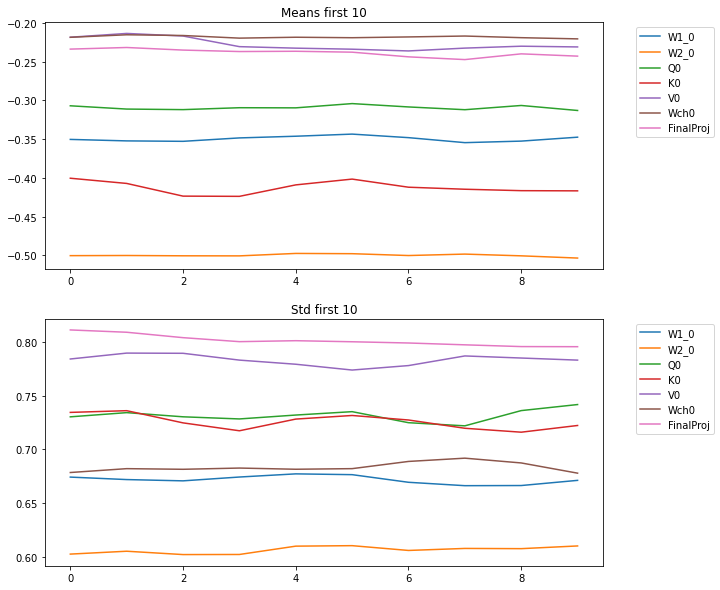

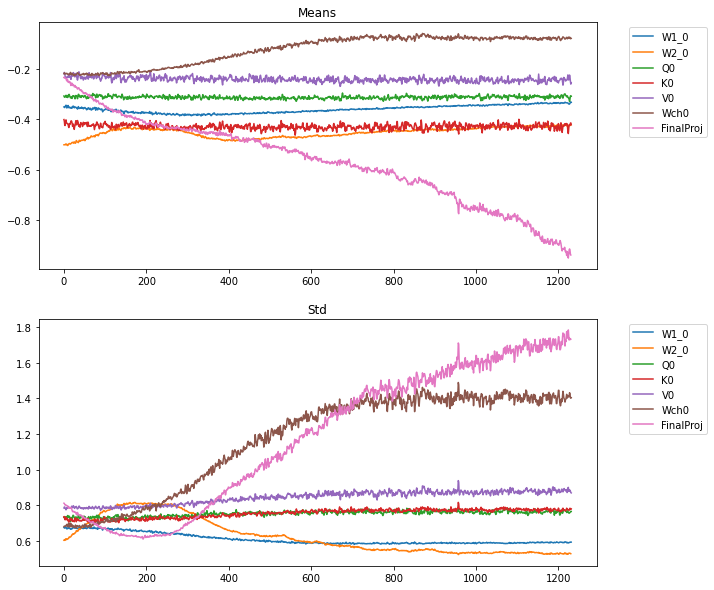

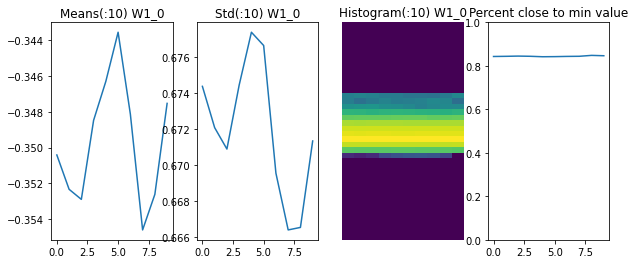

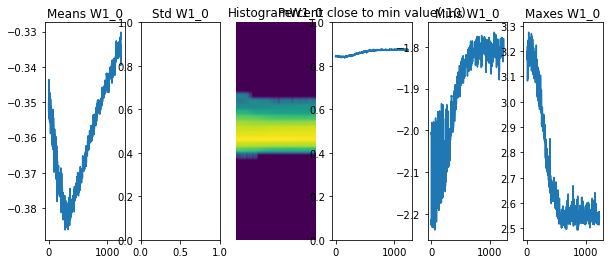

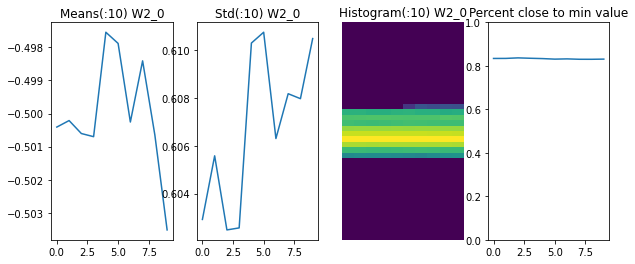

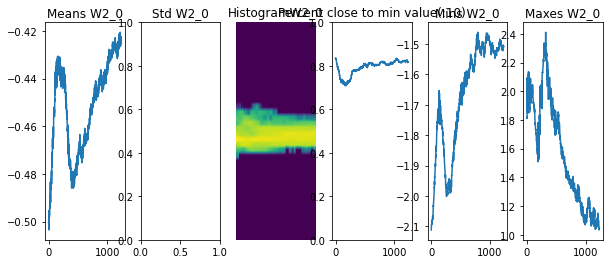

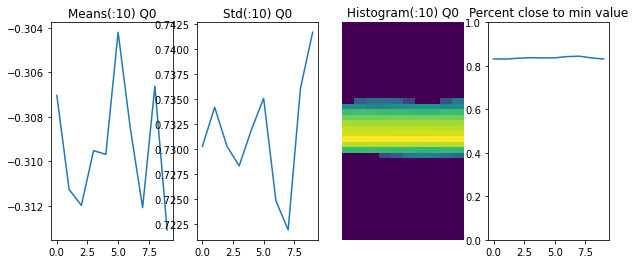

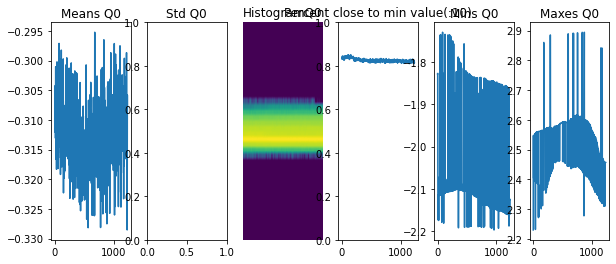

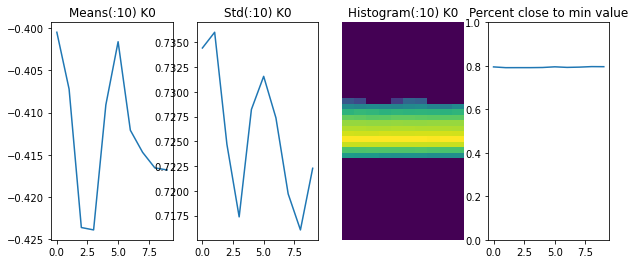

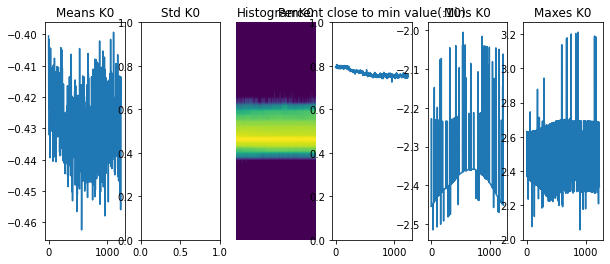

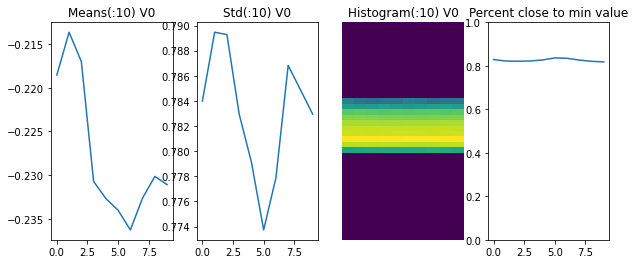

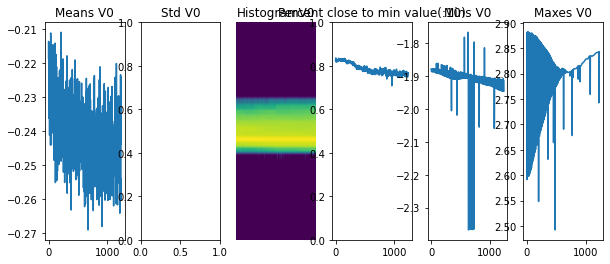

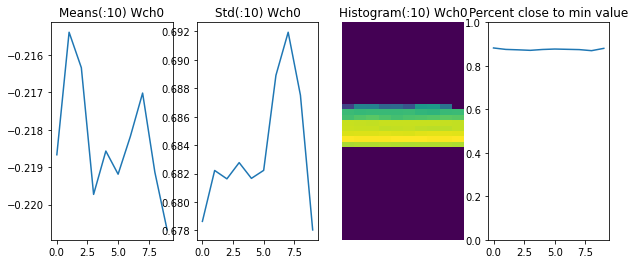

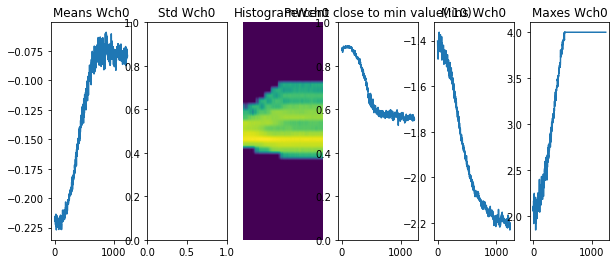

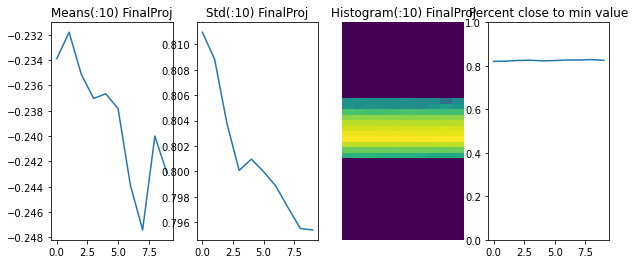

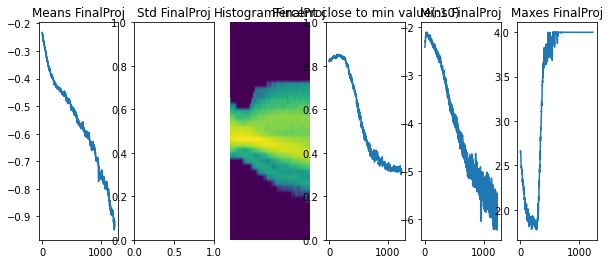

In [680]:
# much of this is from https://github.com/fastai/course-v3/blob/master/nbs/dl2/06_cuda_cnn_hooks_init.ipynb

fig,(ax0,ax1) = plt.subplots(2,1, figsize=(10,10))
for h in hooks.arr:
    if hasattr(h, "stats"):
        ms,ss,hist,mins,maxes = h.stats
        ax0.set_title("Means first 10")
        ax0.plot(ms[:10], label=str(h.m.name))
        ax0.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.set_title("Std first 10")
        ax1.plot(ss[:10], label=str(h.m.name))
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   
fig,(ax0,ax1) = plt.subplots(2,1, figsize=(10,10))
for h in hooks.arr:
    if hasattr(h, "stats"):
        ms,ss,hist,mins,maxes = h.stats
        ax0.set_title("Means")
        ax0.plot(ms, label=str(h.m.name))
        ax0.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.set_title("Std")
        ax1.plot(ss, label=str(h.m.name))
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

def get_min(hist):
    h1 = torch.stack(hist).t().float()
    return h1[18:23].sum(0)/h1.sum(0)
def get_hist(hist): return torch.stack(hist).t().float().log1p()

for h in hooks.arr:
    
    fig,(ax0,ax1,ax2,ax3) = plt.subplots(1,4, figsize=(10,4))
    if hasattr(h, "stats"):
        ms,ss,hist,mins,maxes = h.stats
        ax0.set_title("Means(:10) " + str(h.m.name))
        ax0.plot(ms[:10], label=str(h.m.name))
        ax1.set_title("Std(:10) " + str(h.m.name))
        ax1.plot(ss[:10], label=str(h.m.name))
        ax2.set_title("Histogram(:10) " + str(h.m.name))
        ax2.imshow(get_hist(hist[:10]), origin='lower', aspect="auto")
        ax2.axis('off')
        ax3.set_title("Percent close to min value")
        ax3.plot(get_min(hist[:10]))
        ax3.set_ylim(0,1)
    fig,(ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,6, figsize=(10,4))
    if hasattr(h, "stats"):
        ms,ss,hist,mins,maxes = h.stats
        ax0.set_title("Means " + str(h.m.name))
        ax0.plot(ms, label=str(h.m.name))
        ax1.set_title("Std " + str(h.m.name))
        ax2.set_title("Histogram" + str(h.m.name))
        ax2.imshow(get_hist(hist), origin='lower', aspect="auto")
        ax2.axis('off')
        ax3.set_title("Percent close to min value(:10)")
        ax3.plot(get_min(hist))
        ax3.set_ylim(0,1)
        ax4.set_title("Mins " + str(h.m.name))
        ax4.plot(mins, label=str(h.m.name))
        ax5.set_title("Maxes " + str(h.m.name))
        ax5.plot(maxes, label=str(h.m.name))
    



In [230]:

#train_dataset = SimpleRepeatDataset(nStates=2, nSymbols=2, split='train', sequenceLen=seqLen, numSequences=300000)
#test_dataset = SimpleRepeatDataset(nStates=2, nSymbols=2, split='test', sequenceLen=seqLen, numSequences=1000)
batchSize = 256
tconf = TrainerConfig(max_epochs=100, batch_size=batchSize, learning_rate=6e-5,
                      lr_decay=True, warmup_tokens=0, final_tokens=50*len(train_dataset)*(2+1),
                      num_workers=0)
optimizer = model.configure_optimizers(tconf)
#trainer = Trainer(model, train_dataset, train_dataset, tconf)
#trainer.train()
 
loader = DataLoaderSimple(train_dataset, batchSize)
pbar = tqdm(enumerate(loader), total=len(loader))
for i, (x,y) in pbar:
    logits, loss = model(x, y)
    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
    model.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), tconf.grad_norm_clip)
    optimizer.step()
    pbar.set_description("epoch: " + str(i) + " loss:" + str(loss))
# batch size 64,

'''
batchSize = 64
seqLen = 100
numHeads = 4
embeddingDim = 16
keyDim = 16
valueDim = 16
vocabSize=4
hiddenSize=64
numLayers = 64
warmup_tokens=2048
'''


'''
batchSize = 64
lr=6e-5
seqLen = 100
numHeads = 4
embeddingDim = 16
keyDim = 16
valueDim = 16
vocabSize=4
hiddenSize=64
numLayers = 8
warmup_tokens=2048
'''

# for my model, 256: epoch 1 iter 12088: train loss 2.36522. lr 1.500000e-05: 100%|██████████| 12089/12089 [02:57<00:00, 68.23it/s]
# for my model, 512: epoch 1 iter 12088: train loss 2.34896. lr 1.500000e-05: 100%|██████████| 12089/12089 [03:36<00:00, 55.90it/s]
# for their model, 512: epoch 1 iter 324: train loss 1.98591. lr 5.995246e-05:   3%|▎         | 325/12089 [02:25<1:27:46,  2.23it/s]
# all normalizations: starts lower, but takes longer to converge
# epoch: 6152 loss:tensor(0.0088, grad_fn=<MeanBackward0>):   2%|▏         | 6152/300000 [01:03<50:22, 97.22it/s]
# no layer norm, all normalizations
# epoch: 6052 loss:tensor(0.0096, grad_fn=<MeanBackward0>):   2%|▏         | 6053/300000 [00:59<47:59, 102.09it/s]
# epoch: 9166 loss:tensor(0.0096, grad_fn=<MeanBackward0>):   3%|▎         | 9167/300000 [01:32<48:44, 99.44it/s] 
# no normalizations except /math.sqrt(kDim+0.0) for scores, starts higher but gets to goal sooner
# epoch: 4421 loss:tensor(0.0006, grad_fn=<MeanBackward0>):   1%|▏         | 4422/300000 [00:44<49:45, 99.01it/s]  
# no normalizations at all
# epoch: 2457 loss:tensor(0.0044, grad_fn=<MeanBackward0>):   1%|          | 2458/300000 [00:23<47:57, 103.40it/s]
# epoch: 3751 loss:tensor(0.0058, grad_fn=<MeanBackward0>):   1%|▏         | 3752/300000 [00:37<49:37, 99.51it/s]
# epoch: 2549 loss:tensor(0.0069, grad_fn=<MeanBackward0>):   1%|          | 2550/300000 [00:25<49:42, 99.74it/s] 
# epoch: 1474 loss:tensor(0.0090, grad_fn=<MeanBackward0>):   0%|          | 1475/300000 [00:14<50:08, 99.21it/s] 
# no layer norm and no normalizations
# epoch: 2660 loss:tensor(0.0057, grad_fn=<MeanBackward0>):   1%|          | 2661/300000 [00:27<50:42, 97.73it/s] 
# epoch: 4031 loss:tensor(0.0071, grad_fn=<MeanBackward0>):   1%|▏         | 4031/300000 [00:40<49:32, 99.57it/s]  
# epoch: 934 loss:tensor(0.0077, grad_fn=<MeanBackward0>):   0%|          | 934/300000 [00:03<49:50, 100.21it/s] - started with very low loss already
# epoch: 4009 loss:tensor(0.0079, grad_fn=<MeanBackward0>):   1%|▏         | 4010/300000 [00:38<47:52, 103.03it/s] 
# epoch: 1740 loss:tensor(0.0078, grad_fn=<MeanBackward0>):   1%|          | 1741/300000 [00:17<49:53, 99.63it/s] 

epoch 1 iter 2581: train loss 2.49578. lr 5.704812e-05:  21%|██▏       | 2582/12089 [00:30<01:50, 85.99it/s]


KeyboardInterrupt: 

In [20]:

train_dataset = SimpleRepeatDataset(nStates=2, nSymbols=2, split='train', sequenceLen=seqLen, numSequences=300000)
model(train_dataset[0][0])[0].argmax(axis=2)

tensor([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
         1, 0, 1]])

In [222]:
def testTransformer7():
    b,L,n,d,k,v,vocabSize, hiddenSize, numLayers = 2,3,4,8,6,7,9, 10, 11
    weightLess = 0.5
    offset = 0.5
    numHeads, vocabSize, embeddingDim, keyDim, valueDim, hiddenSize, numLayers = n, vocabSize, d, k, v, hiddenSize, numLayers 
    gpt = Transformer(numHeads=numHeads, vocabSize=vocabSize, embeddingDim=embeddingDim, keyDim=keyDim, valueDim=valueDim, hiddenSize=hiddenSize, numLayers=numLayers, weightLess=weightLess, offset=offset)
    inputs = torch.tensor([[3,4,1],[1,0,2]])
    targets = torch.normal(0, 1, [b,L, vocabSize])
    sm = nn.Softmax(dim=2)
    targets = sm(targets)
    print("targets", targets, targets.shape, targets[0,0], targets[0,0].sum())
    y, losses = gpt(inputs, targets)
    print("y", y, y.shape, (b,L,vocabSize))
    assert(y.shape == (b,L,vocabSize))
    print("losses", losses, losses.shape)
    approx_equals(y.sum(axis=2), torch.ones([b,L]))
    from minGPT.mingpt import model
    from minGPT.mingpt.model import GPT, GPTConfig, GPT1Config
    mconf = GPTConfig(vocabSize, L, n_layer=numLayers, n_head=numHeads, n_embd=embeddingDim)
    model = GPT(mconf)
    from torch.utils.data.dataloader import DataLoader
    data = FastLearnAutomataDataset(nStates=2, nSymbols=2, split='train', sequenceLen=L, numSequences=60)
    print("dats:", data[0], data.sequenceLen)
    loader = DataLoader(data, shuffle=True, pin_memory=True,
                        batch_size=b,
                        num_workers=0)
    for x,y in loader:
        print("datas:", x,y, x.shape, y.shape)
        break
    y2, losses2 = model(x, y)
    y3, losses3 = gpt(x,y)
    print("y2, losses2", y2, y2.shape, losses2, losses2.shape)
    print("y3, losses3", y3, y3.shape, losses3, losses3.shape)
    spooked = y2.view(-1, y2.size(-1))
    print(y2, y2.shape)
    print("spooked", spooked, spooked.shape)
testTransformer7()


targets tensor([[[0.1594, 0.0643, 0.3269, 0.1214, 0.1380, 0.0313, 0.0908, 0.0361,
          0.0319],
         [0.0869, 0.1340, 0.1009, 0.0286, 0.2093, 0.2145, 0.0711, 0.0465,
          0.1082],
         [0.1025, 0.1424, 0.1804, 0.1474, 0.0647, 0.1346, 0.0705, 0.1309,
          0.0266]],

        [[0.4072, 0.0696, 0.1560, 0.0229, 0.0523, 0.2354, 0.0202, 0.0146,
          0.0217],
         [0.0646, 0.1708, 0.0111, 0.0682, 0.0167, 0.0469, 0.5477, 0.0572,
          0.0167],
         [0.0370, 0.0320, 0.1552, 0.1518, 0.0717, 0.1811, 0.0378, 0.2584,
          0.0751]]]) torch.Size([2, 3, 9]) tensor([0.1594, 0.0643, 0.3269, 0.1214, 0.1380, 0.0313, 0.0908, 0.0361, 0.0319]) tensor(1.)
y tensor([[[3.5294e-02, 3.5906e-05, 2.7673e-07, 5.7191e-04, 1.4594e-05,
          1.1280e-01, 1.2557e-07, 9.1254e-03, 8.4216e-01],
         [4.7185e-02, 2.7636e-08, 5.4642e-05, 9.0173e-03, 8.6240e-04,
          9.2805e-01, 1.3350e-02, 3.9484e-06, 1.4714e-03],
         [1.8485e-10, 4.1149e-04, 6.1090e-07, 7.9660e-01

In [205]:
def testCrossEntropy():
    inputs = torch.tensor([[3,4,1],[1,0,2]])
    goals = torch.tensor([[1,2,0],[2,1,1]])
    b,L,n,d,k,v,vocabSize, hiddenSize, numLayers = 2,3,4,8,6,7,9, 10, 11
    weightLess = 0.5
    offset = 0.5
    numHeads, vocabSize, embeddingDim, keyDim, valueDim, hiddenSize, numLayers = n, vocabSize, d, k, v, hiddenSize, numLayers 
    gpt = Transformer(numHeads=numHeads, vocabSize=vocabSize, embeddingDim=embeddingDim, keyDim=keyDim, valueDim=valueDim, hiddenSize=hiddenSize, numLayers=numLayers, weightLess=weightLess, offset=offset)
    y = gpt(inputs)[0]
    print("y", y, y.shape)
    # for goals[b,i] we want to access the value at y[b,i,goals[b,i]]
    # index for goals[b,i] is (b,i,goals[b,i])
    # lets create that index lookup
    
    '''
    torch.gather(input, dim, index) does the following
    out[i][j][k] = input[index[i][j][k]][j][k]  # if dim == 0
    out[i][j][k] = input[i][index[i][j][k]][k]  # if dim == 1
    out[i][j][k] = input[i][j][index[i][j][k]]  # if dim == 2
    
    y is [b,L,vocabSize]
    goals is [b,L]
    we want
    out[bi,l] = y[bi,l,goals[bi,l]]
    but that doesn't fit the above pattern.
    To fix this, we can just do
    out[bi,l,k] = y[bi,l,goals[bi,l,k]]
    where k is only ever 0
    so we need to add that axis to goals
    '''
    values = torch.gather(y, 2, goals.view((b,L,1)))
    
    
    print(values)
    for bi in range(b):
        for l in range(L):
            approx_equals(y[bi,l,goals[bi,l]],values[bi,l])
testCrossEntropy()

y tensor([[[7.1465e-02, 3.2889e-03, 7.0081e-03, 5.4360e-04, 9.1665e-01,
          4.5948e-04, 4.4783e-07, 5.4686e-04, 3.4154e-05],
         [3.5865e-05, 5.2502e-05, 9.9611e-01, 7.6170e-08, 1.2315e-03,
          1.3414e-06, 2.7552e-05, 3.2243e-04, 2.2150e-03],
         [6.8272e-01, 9.1474e-07, 7.7590e-08, 3.2535e-04, 2.5515e-07,
          2.9180e-04, 3.0933e-01, 6.8850e-04, 6.6424e-03]],

        [[6.8272e-01, 9.1474e-07, 7.7590e-08, 3.2535e-04, 2.5515e-07,
          2.9180e-04, 3.0933e-01, 6.8850e-04, 6.6424e-03],
         [1.7251e-06, 1.5701e-07, 1.6659e-08, 9.9988e-01, 8.1252e-08,
          5.6448e-05, 3.0365e-06, 6.0190e-05, 2.8927e-06],
         [1.0939e-05, 3.0040e-03, 1.4954e-04, 2.4149e-04, 1.6799e-04,
          3.0257e-02, 9.6423e-01, 1.7110e-03, 2.2970e-04]]],
       grad_fn=<SoftmaxBackward>) torch.Size([2, 3, 9])
tensor([[[3.2889e-03],
         [9.9611e-01],
         [6.8272e-01]],

        [[7.7590e-08],
         [1.5701e-07],
         [3.0040e-03]]], grad_fn=<GatherBackwar

In [141]:
def testTransformer6():
    b,L,n,d,k,v = 2,3,4,5,6,7
    vocabSize = 10
    embeddingDim = d
    emb = EmbeddingLayer(vocabSize, embeddingDim)
    inputs = torch.tensor([[3,4,1],[1,0,2]])
    print(inputs.shape, inputs)
    print(emb.embeddings)
    e = emb(inputs)
    print(e, e.shape)
testTransformer6()

torch.Size([2, 3]) tensor([[3, 4, 1],
        [1, 0, 2]])
Parameter containing:
tensor([[ 1.1750,  1.5297, -0.8046,  0.9410, -0.4363],
        [-0.6042,  0.6766, -0.9753,  0.7356, -1.0042],
        [-1.1727,  0.5897, -0.2052, -2.0167,  0.1935],
        [ 0.1514, -0.2831, -0.0529,  1.9061, -0.1231],
        [-0.9733,  0.9495,  0.3668,  1.3234,  0.4505],
        [-0.0030,  0.6066, -1.3297, -0.1344, -0.0678],
        [ 1.6767, -0.2011,  0.4436,  0.5443,  0.8576],
        [ 0.8300,  0.7594, -0.9010,  0.4384, -0.2681],
        [-0.5617, -1.4651, -1.0412, -0.4914, -0.4653],
        [-0.9644,  0.8375,  1.8821, -0.8017,  0.1264]], requires_grad=True)
tensor([[[ 0.1514, -0.2831, -0.0529,  1.9061, -0.1231],
         [-0.9733,  0.9495,  0.3668,  1.3234,  0.4505],
         [-0.6042,  0.6766, -0.9753,  0.7356, -1.0042]],

        [[-0.6042,  0.6766, -0.9753,  0.7356, -1.0042],
         [ 1.1750,  1.5297, -0.8046,  0.9410, -0.4363],
         [-1.1727,  0.5897, -0.2052, -2.0167,  0.1935]]],
       gr

In [61]:
def testTransformer5():
    b,L,n,d,k,v = 2,3,4,5,6,7
    attn = MultiHeadSelfAttention(n,d,k,v)
    x = torch.normal(0, 1, [b,L,n,d])
    y = attn(x)
    print("y", y, y.shape)
testTransformer5()

y tensor([[[[ -3.6704,  -9.3205,   4.9568,   0.7842,   1.8210],
          [ -1.8469,  -1.2511,   2.4165,  -8.4936,   2.3370],
          [ -3.7076, -11.2480,  -2.2541,   0.1730,   3.9289],
          [  4.1189,  12.6030,  -2.1638,   0.1501,  -3.8233]],

         [[  1.0092,   3.1251,  -4.8048,  -7.0410,   0.3013],
          [  3.1568,   8.8109,   3.1315,   1.8201,  -2.8351],
          [  3.8105,   5.1023,  -8.9080,   7.9049,  -3.8480],
          [  2.3823,   9.4847,   2.0629,  -4.3741,  -2.1458]],

         [[  1.2555,   2.0134,  -4.1270,   4.3320,  -1.9510],
          [  2.0929,   5.9423,   2.8129,   3.4904,  -2.7486],
          [  3.3003,   4.9170,  -7.2156,   7.2499,  -3.3391],
          [  0.2540,   5.4972,   6.9223,  -9.5532,  -0.1014]]],


        [[[  1.1796,   5.4335,  -1.8405, -11.9477,   1.3111],
          [ -0.0435,  -2.5657,  -1.9573,  -3.5210,  -0.3614],
          [  3.9728,   3.3343,  -5.2243,  18.5582,  -5.8535],
          [  4.3869,  10.8971,  -0.3297,  12.2588,  -4.5315]

In [20]:
def testTransformer4():
    b,L,n,d,k,v = 2,3,4,5,6,7
    inds = torch.tensor(range(L))
    sm = torch.nn.Softmax(dim=1)
    a = torch.normal(0, 1, [b,L,n])
    print(a)
    a[:,inds>1,:] = np.NINF
    print(a)
    print(sm(a))
    print(sm(a)[0,:,1])
    
testTransformer4()

tensor([[[ 0.2370,  0.5129,  0.0639, -3.6355],
         [ 0.8274,  1.5479,  0.1948,  0.0440],
         [ 0.7549,  0.3560, -0.0806, -0.6300]],

        [[ 0.9438,  0.6535,  0.1992, -1.4359],
         [ 0.2629,  0.8505,  1.1858,  0.5235],
         [ 1.4031,  0.4500,  1.0992, -1.3850]]])
tensor([[[ 0.2370,  0.5129,  0.0639, -3.6355],
         [ 0.8274,  1.5479,  0.1948,  0.0440],
         [   -inf,    -inf,    -inf,    -inf]],

        [[ 0.9438,  0.6535,  0.1992, -1.4359],
         [ 0.2629,  0.8505,  1.1858,  0.5235],
         [   -inf,    -inf,    -inf,    -inf]]])
tensor([[[0.3565, 0.2621, 0.4673, 0.0246],
         [0.6435, 0.7379, 0.5327, 0.9754],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.6639, 0.4509, 0.2716, 0.1235],
         [0.3361, 0.5491, 0.7284, 0.8765],
         [0.0000, 0.0000, 0.0000, 0.0000]]])
tensor([0.2621, 0.7379, 0.0000])


In [29]:
def testTransformer3():
    b, n, d, k, m = 2,3,4,5,6
    set_seed(27)
    a = torch.normal(0, 1, [b,d])
    b = a.view((b,1,d)).expand((b,n,d))
    print(b, b.shape, b.stride(), b.storage())
    x = torch.normal(0, 1, [b,n,d])
    
    
testTransformer3()

tensor([[[ 0.5664, -0.5493,  1.2395,  0.8272],
         [ 0.5664, -0.5493,  1.2395,  0.8272],
         [ 0.5664, -0.5493,  1.2395,  0.8272]],

        [[ 1.1796,  1.9616, -0.0884,  1.1684],
         [ 1.1796,  1.9616, -0.0884,  1.1684],
         [ 1.1796,  1.9616, -0.0884,  1.1684]]]) torch.Size([2, 3, 4]) (4, 0, 1)  0.5664487481117249
 -0.5492674112319946
 1.2395411729812622
 0.8271635174751282
 1.1796386241912842
 1.9616155624389648
 -0.0884392186999321
 1.1684051752090454
[torch.FloatStorage of size 8]


TypeError: normal(): argument 'size' must be tuple of ints, but found element of type Tensor at pos 1

In [17]:
def testEmbeddings():
    nWords, embeddingDim = 3, 4
    embedding = EmbeddingLayer(nWords, embeddingDim)
    inputs = torch.tensor([[0,2,1, 2, 1]]).reshape(5)
    print(inputs)
    print(embedding(inputs).shape)
testEmbeddings()
    
    
    

tensor([0, 2, 1, 2, 1])
torch.Size([5, 4])


In [17]:
def testTransformer2():
    b, n, d, k = 2, 3, 4, 5
    set_seed(27)
    dotQueryKey = torch.normal(0, 1, [b,n,n])
    softmax = torch.nn.Softmax(dim=2)
    queryPrs = softmax(dotQueryKey)
    vh = torch.normal(0, 1, [b,n,k])
    print("qprs", queryPrs)
    print("vh", vh)
    # the ith output is taking sum over j of (queryPrs[b,i,j])*(vh[b,j])
    #                            scalar            vector
    # queryPrs is [b,n,n]
    # vh       is [b,n,k]
    # so         queryPrs[b,i] is of dim n
    #            vh[b]         is of dim [n,k]
    # so         j ranges from 0 to n-1
    # fixing b and i and thinking of this as a small matrix, we do
    # queryPrs = [0.4, 0.6] (n of these)
    #              
    # vh       = [1.2,     3.4,     5.2] (each row is of length k)
    #          = [3.4,     2.3,     1.1] (there are n rows)
    # we do
    #            [0.4*1.2, 0.4*3.4, 0.4*5.2 ]
    #            [0.6*3.4, 0.6*2.3, 0.6*1.1 ]
    # and then we sum them:
    #            [0.4*1.2+0.6*3.4, 0.4*3.4+0.6*2.3, 0.4*5.2+0.6*1.1]
    # In other words, for a given i we dot the ith row of queryPrs[b] (dim n) by each column in vh[b] (vh[b] is [n,k], so each column is dim n)
    # Thus, the output's [b,i,j] value is the ith row of queryPrs[b] dot the jth column of vh[b] 
    # for regular matrix multiplication of A and B, the [i,j]th value is ith row of A dot jth column of B, so this is just regular matrix multiplication.
    # In einsum: torch.einsum("bij,bjk->bik")
    # which means that our output[b,i] is
    summedRows = torch.einsum("bij,bjk->bik", queryPrs, vh)
    for bi in range(b):
        approx_equals(summedRows[bi, 0,0], queryPrs[bi, 0]@vh[bi, :,0])
        approx_equals(summedRows[bi, 0,1], queryPrs[bi, 0]@vh[bi, :,1])
        approx_equals(summedRows[bi, 1,0], queryPrs[bi, 1]@vh[bi, :,0])
        approx_equals(summedRows[bi, 1,1], queryPrs[bi, 1]@vh[bi, :,1])
    print("summedRows", summedRows)
    
    # we are currently [b,n,k],
    # now we need to project res back to a [b,n,d] size
    Wch = torch.normal(0, 1, [d,k])
    
    res = torch.einsum("dk,bnk->bnd", Wch, summedRows)
    for bi in range(b):
        approx_equals(res[bi,0,0], Wch[0]@summedRows[bi, 0,0])
        approx_equals(res[bi,0,1], Wch[0]@summedRows[bi, 0,0])
        approx_equals(res[bi,0,0], Wch[0]@summedRows[bi, 0,0])
        approx_equals(res[bi,0,0], Wch[0]@summedRows[bi, 0,0])
    print(res[0,0,1], Wch[1]@summedRows[0,0])
    
    a = torch.normal(0, 1, [2, 3])
    b = torch.normal(0, 1, [2, 3, 4])
    
testTransformer2()

qprs tensor([[[0.7313, 0.1338, 0.1350],
         [0.1290, 0.5566, 0.3144],
         [0.2761, 0.6204, 0.1035]],

        [[0.1808, 0.0482, 0.7710],
         [0.1420, 0.2864, 0.5716],
         [0.5909, 0.2983, 0.1109]]])
vh tensor([[[ 0.4601,  0.3644, -1.4775,  0.4753, -0.3383],
         [-0.5367,  1.5008, -0.7286,  0.4594,  0.4356],
         [-0.2073, -1.0252, -1.1372,  1.0307,  0.4656]],

        [[-0.8964,  0.5814, -0.9950, -0.9881, -0.1613],
         [ 0.1007,  0.9505,  0.9992, -0.8928,  1.6873],
         [ 0.4901,  0.2179,  0.0329,  0.0506, -0.0541]]])
summedRows tensor([[[ 0.2367,  0.3289, -1.3314,  0.5481, -0.1263],
         [-0.3046,  0.5601, -0.9537,  0.6411,  0.3452],
         [-0.2274,  0.9256, -0.9777,  0.5229,  0.2250]],

        [[ 0.2207,  0.3189, -0.1064, -0.1826,  0.0104],
         [ 0.1817,  0.4793,  0.1637, -0.3671,  0.4293],
         [-0.4452,  0.6512, -0.2862, -0.8445,  0.4019]]])
tensor(-0.9102) tensor(-0.9102)


In [89]:
def testTransformer():
    b, n, d, k = 2, 3, 4, 5
    from minGPT.mingpt.utils import set_seed
    set_seed(27)
    x = torch.normal(0, 1, [b,n,d])
    print("x:", x)
    x
    Q = torch.normal(0, 1, [k,d])
    K = torch.normal(0, 1, [k,d])
    V = torch.normal(0, 1, [k,d])
    # In other words
    print("Q:", Q)
    res = torch.einsum('kd,bnd->bnk', Q, x)
    # Check that it's the same both ways
    approx_equals(Q@(x[0,0]), res[0,0])
    approx_equals(Q@(x[1,0]), res[1,0])
    approx_equals(Q@(x[0,1]), res[0,1])
    approx_equals(Q@(x[1,1]), res[1,1])
    
    q = torch.einsum("kd,bnd->bnk", Q, x)
    k = torch.einsum("kd,bnd->bnk", Q, x)
    v = torch.einsum("kd,bnd->bnk", Q, x)
    
    print("q:", q)
    print("k:", k)
    dotQueryKey = torch.einsum("bij, bkj->bik", q, k)
    print("dq", dotQueryKey.shape, dotQueryKey)
    
    # dotQueryKey[b,i,j] is q[b,i] dot k[b,j]
    for ba in range(b):
        approx_equals(q[ba,0]@k[ba,0], dotQueryKey[ba,0,0])
        approx_equals(q[ba,0]@k[ba,1], dotQueryKey[ba,0,1])
        approx_equals(q[ba,1]@k[ba,0], dotQueryKey[ba,1,0])
        approx_equals(q[ba,1]@k[ba,1], dotQueryKey[ba,1,1])
    
testTransformer()

x: tensor([[[ 1.7650,  0.0664, -0.0706, -0.1672],
         [-0.4266,  1.5005, -0.2636, -1.0210],
         [-1.7975, -0.3770,  0.6140,  0.5948]],

        [[-0.8629, -0.9511, -0.9195, -0.7592],
         [ 0.3197, -0.6699,  1.5661,  0.8074],
         [-1.6036,  0.1696, -0.0308,  0.0434]]])
Q: tensor([[ 1.5008, -0.7286, -0.5098,  0.4431],
        [-0.9389,  1.5772,  1.6559, -0.4713],
        [ 0.4656, -0.8964,  0.5814, -0.9950],
        [ 0.6763,  0.1337,  0.0659,  0.5385],
        [ 0.9992, -0.8928,  1.6873,  0.4901]])
q: tensor([[[ 2.5625, -1.5905,  0.8876,  1.1078,  1.5033],
         [-2.0517,  2.8120, -0.6810, -0.6551, -2.7111],
         [-2.4725,  1.8294, -0.7338, -0.9053, -0.1320]],

        [[-0.4698, -1.8548,  0.6716, -1.1802, -1.9367],
         [ 0.5273,  0.8561,  0.8565,  0.6647,  3.9557],
         [-2.4954,  1.7016, -0.9597, -1.0404, -1.7845]]])
k: tensor([[[ 2.5625, -1.5905,  0.8876,  1.1078,  1.5033],
         [-2.0517,  2.8120, -0.6810, -0.6551, -2.7111],
         [-2.4725, 

In [85]:
from minGPT.mingpt.utils import set_seed
set_seed(27)
a = torch.normal(0, 1, [4, 5])
b = torch.normal(0, 1, [5, 4])
print("a", a)
print("b", b)
print(a[0]@b[:,0])
torch.einsum("ij,jk->ik", a, b)
set_seed(27)
print("later stuff")
a = torch.normal(0, 1, [4, 5])
b = torch.normal(0, 1, [4, 5])
print(a[0]@b[0])
print(a[0]@b[1])
print(a[1]@b[0])
print(a[1]@b[1])
# we want to go from a [nxm],[nxm] to a [n,n]
torch.einsum("ij,kj->ik", a, b)

a tensor([[ 1.7650,  0.0664, -0.0706, -0.1672,  0.0756],
        [-0.4957, -0.8165, -0.0069, -1.7975, -0.3770],
        [ 0.6140,  0.5948, -0.1926,  0.5088,  1.2001],
        [ 1.0033,  0.3197, -0.6699,  1.5661,  0.8074]])
b tensor([[-1.4775,  0.4753, -0.3383, -0.5367],
        [-0.8237, -0.4236,  0.3272, -1.9896],
        [-0.9389,  1.5772,  1.6559, -0.4713],
        [ 0.2374, -0.1400, -1.0862,  0.5188],
        [ 0.6763,  0.1337,  0.0659,  0.5385]])
tensor(-2.5848)
later stuff
tensor(-2.5248)
tensor(-0.3093)
tensor(1.6219)
tensor(1.0495)


tensor([[-2.5248, -0.3093,  2.8159,  0.9808],
        [ 1.6219,  1.0495,  0.2236, -1.1318],
        [-1.8210,  1.7328, -0.6841,  1.3748],
        [-2.6093,  0.8155,  0.2554,  1.1852]])

In [102]:
from minGPT.mingpt.utils import set_seed
set_seed(27)
a = torch.normal(0, 1, [2, 3, 4])
print(a)

softmax(a)[0,1].sum()

tensor([[[ 1.7650,  0.0664, -0.0706, -0.1672],
         [-0.4266,  1.5005, -0.2636, -1.0210],
         [-1.7975, -0.3770,  0.6140,  0.5948]],

        [[-0.8629, -0.9511, -0.9195, -0.7592],
         [ 0.3197, -0.6699,  1.5661,  0.8074],
         [-1.6036,  0.1696, -0.0308,  0.0434]]])


tensor(1.0000)

In [ ]:
bn = LayerNorm(10)
inputs = torch.normal(0, 1, [30, 10])
ayy = bn(inputs)
print(ayy.mean(), ayy.std())